In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import Adam

from GlaucomaDataset import GlaucomaDataset
from unet import UNet

### Read in and load Origa data

In [14]:
origa_path = os.path.join("..", "data", "ORIGA")
images_path = os.path.join(origa_path, "Images_Square")
masks_path = os.path.join(origa_path, "Masks_Square")

img_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))

In [15]:
# Split into train, validation, and test sets (70, 15, 15)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    img_filenames, mask_filenames, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42)

In [16]:
# Load data
batch_size = 8
n_workers = 4

train_set = GlaucomaDataset(images_path, masks_path, train_imgs, train_masks)
val_set = GlaucomaDataset(images_path, masks_path, val_imgs, val_masks)
test_set = GlaucomaDataset(images_path, masks_path, test_imgs, test_masks)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=n_workers, shuffle=True)

### Define metrics

In [17]:
def dice_coefficient(targets, preds, smooth=1e-6):
    # preds = (preds > 0.5).float 
    intersection = torch.sum(preds * targets, dim=(2,3))
    # want close to 1 (identical)
    dice = (2. * intersection + smooth) / (torch.sum(preds, dim=(2,3)) + torch.sum(targets, dim=(2,3)) + smooth)
    return dice.mean()

### Train and test loop

In [18]:
def trainloop(dataloader, model, loss_func, optimizer):
    num_batches = len(dataloader)
    train_loss, dice = 0., 0. 
    
    for image, image_name, mask, mask_name in dataloader:
        image, mask = image.to(device), mask.to(device)
        
        optimizer.zero_grad()
        pred = model(image)
        loss = loss_func(pred, mask)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        dice += dice_coefficient(pred, mask).item()
    train_loss /= num_batches
    dice /= num_batches
        
    return train_loss, dice

def testloop(dataloader, model, loss_func):
    num_batches = len(dataloader)
    test_loss, dice = 0. , 0.
    
    with torch.no_grad():
        for image, image_name, mask, mask_name in dataloader:
            image, mask = image.to(device), mask.to(device)
            pred = model(image)
            test_loss += loss_func(pred, mask).item()
            dice += dice_coefficient(pred, mask).item()
    test_loss /= num_batches
    dice /= num_batches
    
    return test_loss, dice

### Initialize and train model

In [10]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)

lr = 1e-4
loss_func = torch.nn.BCELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=lr)

In [14]:
# Training and validation
epochs = 60

for epoch in range(epochs):
    
    model.train()
    train_loss, dice = trainloop(train_loader, model, loss_func, optimizer)
    print(f"---Epoch {epoch+1}/{epochs}:---")
    print(f"Train Loss: {train_loss:.4f}   Train Dice: {dice:.4f}")
    
    model.eval()
    test_loss, dice = testloop(val_loader, model, loss_func)
    print(f"Test Error: \n Avg Loss: {test_loss:>8f}  Test Dice: {dice:.4f} \n")

---Epoch 1/60:---
Train Loss: 0.0042   Train Dice: 0.8440
Test Error: 
 Avg Loss: 0.004756  Test Dice: 0.8365 

---Epoch 2/60:---
Train Loss: 0.0042   Train Dice: 0.8380
Test Error: 
 Avg Loss: 0.004478  Test Dice: 0.8437 

---Epoch 3/60:---
Train Loss: 0.0041   Train Dice: 0.8427
Test Error: 
 Avg Loss: 0.004502  Test Dice: 0.8334 

---Epoch 4/60:---
Train Loss: 0.0040   Train Dice: 0.8470
Test Error: 
 Avg Loss: 0.004356  Test Dice: 0.8377 

---Epoch 5/60:---
Train Loss: 0.0039   Train Dice: 0.8493
Test Error: 
 Avg Loss: 0.004335  Test Dice: 0.8501 

---Epoch 6/60:---
Train Loss: 0.0039   Train Dice: 0.8505
Test Error: 
 Avg Loss: 0.004197  Test Dice: 0.8363 

---Epoch 7/60:---
Train Loss: 0.0039   Train Dice: 0.8478
Test Error: 
 Avg Loss: 0.004550  Test Dice: 0.8380 

---Epoch 8/60:---
Train Loss: 0.0038   Train Dice: 0.8511
Test Error: 
 Avg Loss: 0.004258  Test Dice: 0.8519 

---Epoch 9/60:---
Train Loss: 0.0043   Train Dice: 0.8406
Test Error: 
 Avg Loss: 0.004913  Test Dice: 0

In [15]:
# Save model
torch.save(model.state_dict(), 'model_state_dict.pth')

### Test predictions

In [16]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)
path = os.path.join(os.getcwd(), "model_state_dict.pth")
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

In [26]:
def predict_masks(test_iter, model, loss_func):
    
    image_batch, image_filename, mask_batch, mask_filename = next(test_iter)
    image = image_batch[0]
    mask = mask_batch[0]
    image = image.unsqueeze(0).to(device) # add batch dim
    mask = mask.to(device)

    with torch.no_grad():
        pred = model(image)

    od_loss = loss_func(pred[0][0], mask[0])
    oc_loss = loss_func(pred[0][1], mask[1])

    print(f"Optic Disc Loss: {od_loss}")
    print(f"Optic Cup Loss: {oc_loss}")

    pred = pred.squeeze(0).cpu().numpy()
    mask = mask.cpu().numpy()
    pred_od = pred[0]
    pred_oc = pred[1]
    pred_od = (pred_od > 0.5).astype(int)
    pred_oc = (pred_oc > 0.5).astype(int)

    image = image.squeeze().cpu().numpy().transpose(1,2,0)
    
    # Plot overlay of masks
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    color_mask = np.zeros_like(image)
    color_mask[mask[0] == 1] = 255
    od_mask = color_mask

    color_mask = np.zeros_like(image)
    color_mask[mask[1] == 1] = 255
    oc_mask = color_mask

    color_mask = np.zeros_like(image)
    color_mask[pred_od == 1] = 255
    od_mask_pred = color_mask

    color_mask = np.zeros_like(image)
    color_mask[pred_oc == 1] = 255
    oc_mask_pred = color_mask

    ax[0].imshow(image)
    ax[0].imshow(od_mask, alpha=0.3)
    ax[0].imshow(oc_mask, alpha=0.15)
    ax[0].set_title("Ground Truth Masks")

    ax[1].imshow(image)
    ax[1].imshow(od_mask_pred, alpha=0.3)
    ax[1].imshow(oc_mask_pred, alpha=0.15)
    ax[1].set_title("Predicted Masks")
    
    return mask, pred_od, pred_oc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.0015708201099187136
Optic Cup Loss: 0.0025777164846658707


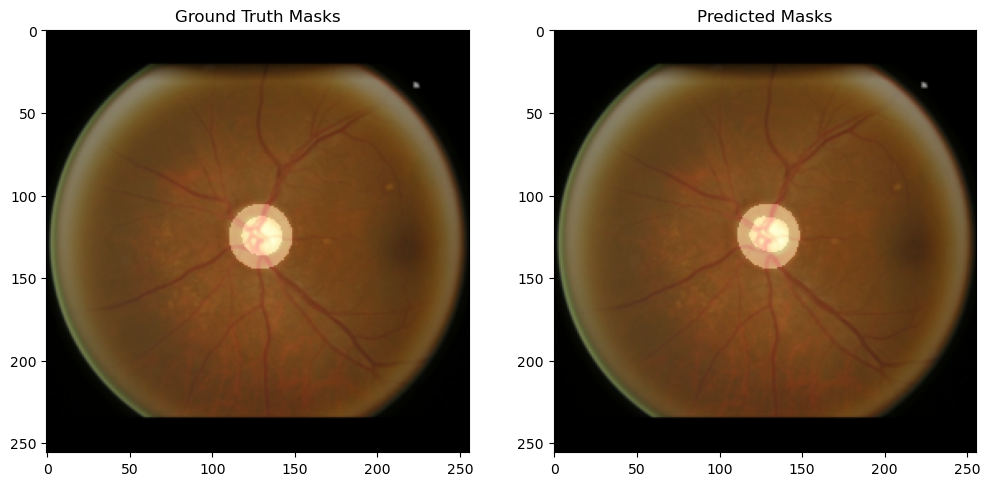

In [31]:
model.eval()

test_iter = iter(test_loader)
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

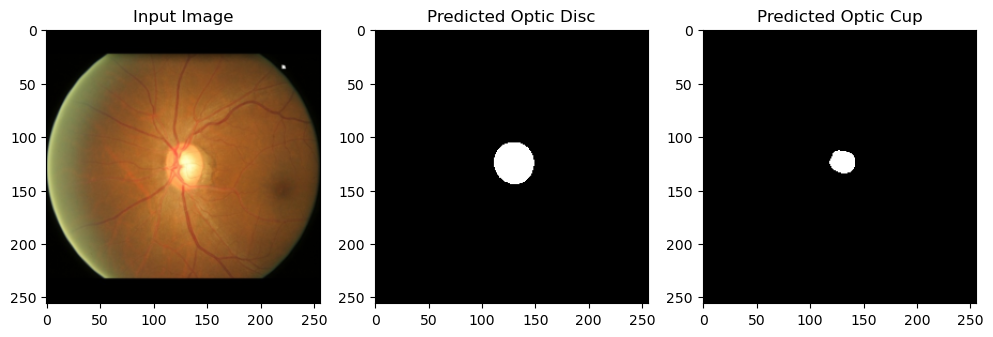

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(image)
ax[0].set_title("Input Image")

ax[1].imshow(pred_od, cmap='gray')  # Ground Truth Optic Disc
ax[1].set_title("Predicted Optic Disc")

ax[2].imshow(pred_oc, cmap='gray')  # Predicted Optic Disc
ax[2].set_title("Predicted Optic Cup")

plt.show()

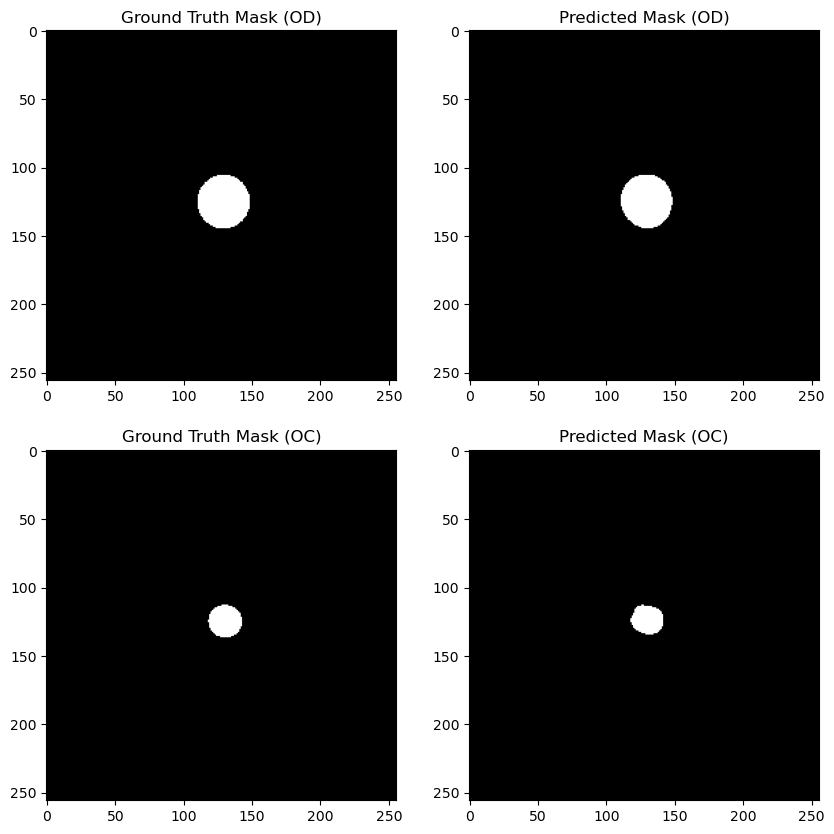

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].imshow(mask[0], cmap='gray')
ax[0,0].set_title("Ground Truth Mask (OD)")

ax[0,1].imshow(pred_od, cmap='gray')
ax[0,1].set_title("Predicted Mask (OD)")

ax[1,0].imshow(mask[1], cmap='gray')
ax[1,0].set_title("Ground Truth Mask (OC)")

ax[1,1].imshow(pred_oc, cmap='gray')
ax[1,1].set_title("Predicted Mask (OC)")

plt.show()

## Hybrid BCE and Dice Loss

In [28]:
from torch import nn

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5, smooth=1e-5):
        super(BCEDiceLoss, self).__init__()
        self.bce_loss = torch.nn.BCELoss(reduction='mean')
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.smooth = smooth
        
    def dice(self, pred, target):
        """Computes dice loss"""
        # Sums on channel, height, width dimensions 
        while pred.dim() < 4:
            pred = pred.unsqueeze(0)
        while target.dim() < 4: 
            target = target.unsqueeze(0)
            
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
    
    def forward(self, preds, target):
        """Computes hybrid BCE and dice loss"""
        bce = self.bce_loss(preds, target)
        dice = self.dice(preds, target)
        loss = bce * self.bce_weight + dice * self.dice_weight
        return loss

### Initialize and train model

In [90]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)

lr = 1e-4
loss_func = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = Adam(model.parameters(), lr=lr)

In [71]:
# Training and validation
epochs = 60

for epoch in range(epochs):
    
    model.train()
    train_loss, dice = trainloop(train_loader, model, loss_func, optimizer)
    print(f"---Epoch {epoch+1}/{epochs}:---")
    print(f"Train Loss: {train_loss:.4f}   Train Dice: {dice:.4f}")
    
    model.eval()
    test_loss, dice = testloop(val_loader, model, loss_func)
    print(f"Test Error: \n Avg Loss: {test_loss:>8f}  Test Dice: {dice:.4f} \n")

---Epoch 1/60:---
Train Loss: 0.4997   Train Dice: 0.0753
Test Error: 
 Avg Loss: 0.348507  Test Dice: 0.3343 



KeyboardInterrupt: 

In [37]:
# Save trained model for future reference
torch.save(model.state_dict(), 'model_hybrid_state_dict.pth')

### Test predictions

In [84]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3).to(device)
path = os.path.join(os.getcwd(), "model_hybrid_state_dict.pth")
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

In [85]:
test_iter = iter(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.014853212982416153
Optic Cup Loss: 0.0931219756603241


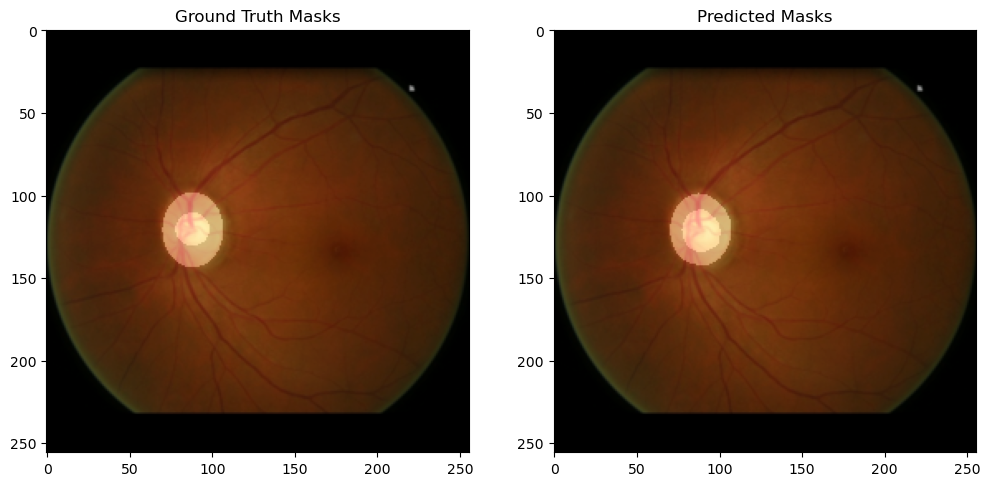

In [86]:
model.eval()

test_iter = iter(test_loader)
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

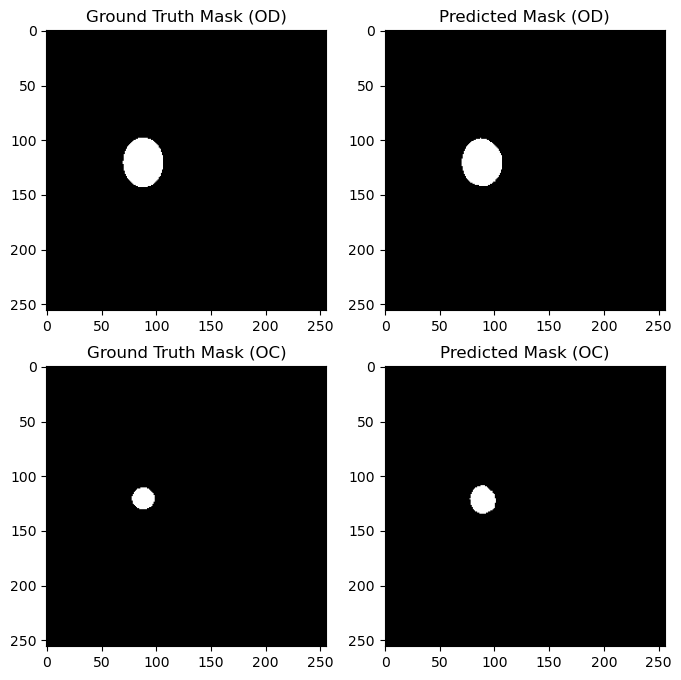

In [87]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].imshow(mask[0], cmap='gray')
ax[0,0].set_title("Ground Truth Mask (OD)")

ax[0,1].imshow(pred_od, cmap='gray')
ax[0,1].set_title("Predicted Mask (OD)")

ax[1,0].imshow(mask[1], cmap='gray')
ax[1,0].set_title("Ground Truth Mask (OC)")

ax[1,1].imshow(pred_oc, cmap='gray')
ax[1,1].set_title("Predicted Mask (OC)")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.024935662746429443
Optic Cup Loss: 0.1052006259560585


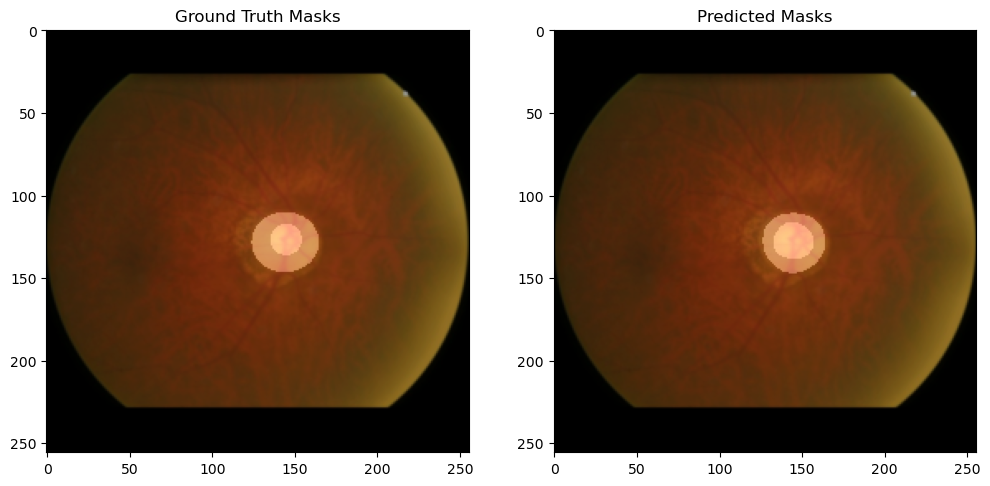

In [88]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Optic Disc Loss: 0.07070417702198029
Optic Cup Loss: 0.03708663955330849


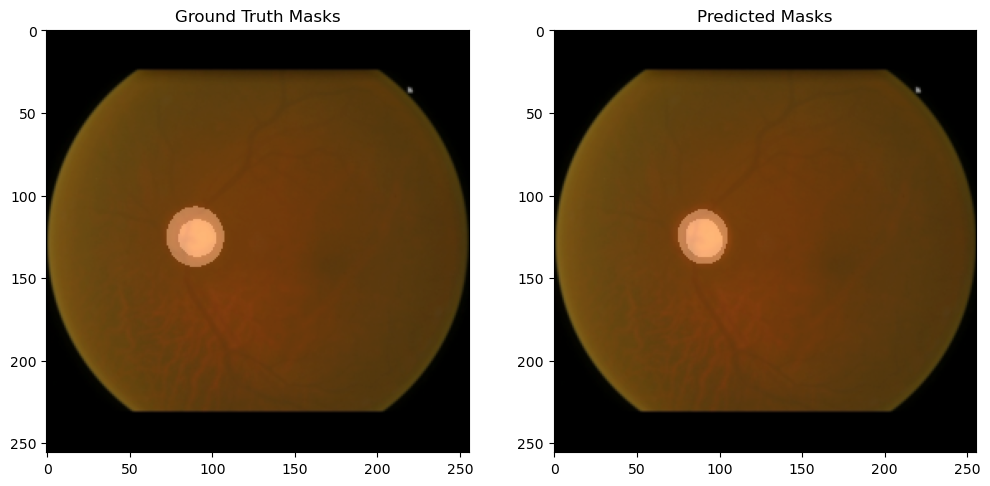

In [89]:
mask, pred_od, pred_oc = predict_masks(test_iter, model, loss_func)

### Pre-trained weights

In [25]:
from mri_unet import UNet as MRI_UNet

In [26]:
# Load in model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MRI_UNet(in_channels=3).to(device)
# path = os.path.join(os.getcwd(), "unet.pt")
model.load_state_dict(torch.load("mri_unet.pt", weights_only=True, map_location=device))

<All keys matched successfully>

In [29]:
lr = 1e-4
loss_func = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = Adam(model.parameters(), lr=lr)